# Notes
Added terrain options

Switched order of Nx and Ny in some of the code. Use: Ny, Nx in this order. Ny = #rows, Nx = # columns

In [8]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
import numpy as np
from datetime import datetime
import ipdb
from scipy.ndimage import imread

In [130]:
   class Hexgrid():
    def __init__(self, Nx, Ny, repositeAngle = np.deg2rad(10), dx=1, terrain=None):
        self.Nx = Nx
        self.Ny = Ny
#         self.height = np.zeros((self.Nx,self.Ny))
        self.height = np.ones((self.Ny,self.Nx)) * np.inf # Had to put in a border
        self.height[1:self.Ny-1,1:self.Nx-1] = 0
        
        self.dx = dx
        self.repositeAngle = repositeAngle
        self.X = np.zeros((Ny, Nx, 2)) # X[:,:,0] = X coords, X[:,:,1] = Y coords
        for j in range(Ny):
            self.X[j,:,0] = j*dx/2 + np.arange(Nx) * dx    
            self.X[j,:,1] = -np.ones(Nx) * dx*np.sqrt(3)/2 * j
        
        if terrain is not None:
            self.seaBed = terrain
        else:
            self.seaBed = np.zeros((self.Ny,self.Nx))
        self.totalheight = self.height + self.seaBed
        
        # Calculate the differences between the sea bed heights for all cell - neighbor pairs
        self.seaBedDiff= np.zeros((self.Ny-2,self.Nx-2,6))
        self.seaBedDiff[:,:,0] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[0:self.Ny-2, 1:self.Nx-1]
        self.seaBedDiff[:,:,1] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[0:self.Ny-2, 2:self.Nx  ]
        self.seaBedDiff[:,:,2] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[1:self.Ny-1, 2:self.Nx  ]
        self.seaBedDiff[:,:,3] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[2:self.Ny  , 1:self.Nx-1]
        self.seaBedDiff[:,:,4] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[2:self.Ny  , 0:self.Nx-2]
        self.seaBedDiff[:,:,5] = self.seaBed[1:self.Ny-1,1:self.Nx-1] - self.seaBed[1:self.Ny-1, 0:self.Nx-2]
        
            
    def update_heightNew(self):        
        # First, make copy of current height array
        old_height = self.height.copy()        
        interiorH = old_height[1:self.Ny-1,1:self.Nx-1]
        
        diff = np.zeros((self.Ny-2,self.Ny-2,6))
        angle = np.zeros((self.Ny-2,self.Ny-2,6))
        indices = np.zeros((self.Ny-2,self.Ny-2,6))
        NoOfTrans = np.zeros((self.Ny-2,self.Nx-2))
        frac  = np.zeros((self.Ny-2,self.Nx-2,6))
        deltaS = np.zeros((self.Ny-2,self.Nx-2,6))
        deltaSSum = np.zeros((self.Ny-2,self.Nx-2))

        # Calculate height differences of all neighbors
        diff[:,:,0] =  interiorH - old_height[0:self.Ny-2, 1:self.Nx-1] + self.seaBedDiff[:,:,0] 
        diff[:,:,1] =  interiorH - old_height[0:self.Ny-2, 2:self.Nx  ] + self.seaBedDiff[:,:,1]
        diff[:,:,2] =  interiorH - old_height[1:self.Ny-1, 2:self.Nx  ] + self.seaBedDiff[:,:,2]
        diff[:,:,3] =  interiorH - old_height[2:self.Ny  , 1:self.Nx-1] + self.seaBedDiff[:,:,3]
        diff[:,:,4] =  interiorH - old_height[2:self.Ny  , 0:self.Nx-2] + self.seaBedDiff[:,:,4]  # Gir error med terreng!
        diff[:,:,5] =  interiorH - old_height[1:self.Ny-1, 0:self.Nx-2] + self.seaBedDiff[:,:,5] # Gir error med terreng og NW + NE
        
        
        # Find angles
        for i in np.arange(6):
            angle[:,:,i] = np.arctan(diff[:,:,i]/self.dx) # Angle between "my cell" and the one in the north west
        
        
        # (Checks if cell (i,j) has angle > reposite angle and that it has mass > 0. For all directions.)      
        # Find cells (i,j) for which to transfer mass in the direction given
        for i in np.arange(6):
            indices[:,:,i] = np.logical_and(angle[:,:,i]>self.repositeAngle, (interiorH > 0) )  # Gives indices (i,j) where the current angle > reposite angle and where height is > 0
        
        
        # Count up the number of cells (i,j) will be transfering mass to. If none, set (i,j) to infinity so that division works.
        for i in np.arange(6):
            NoOfTrans += indices[:,:,i]
        NoOfTrans[NoOfTrans == 0] = np.inf
    

        # Calculate fractions of mass to be transfered
        for i in np.arange(6): # Buggen ligger her. Formelen kan gi tall >1, når f.eks diff = 5.15 og interiorH = 1.34
            frac[(indices[:,:,i]>0),i] = (0.5 * (diff[(indices[:,:,i]>0),i] - self.dx * np.tan(self.repositeAngle))/interiorH[(indices[:,:,i]>0)])
        # Dirty fix that does not work... Should find an alternative solution.
        frac[frac>1] = 0.9

  
        for i in np.arange(6): 
            deltaS[(indices[:,:,i]>0),i] = interiorH[(indices[:,:,i]>0)] * frac[(indices[:,:,i]>0),i]/NoOfTrans[(indices[:,:,i]>0)] # Mass to be transfered from index [i,j] to index [i-1,j]
        
        
        # Lag en endringsmatrise deltaSSum som kan legges til self.height
        # Trekk fra massen som skal sendes ut fra celler
        for i in np.arange(6):
            deltaSSum -= deltaS[:,:,i]
#         ipdb.set_trace()


        
        
        # Legg til massen som skal tas imot
        deltaSSum[np.where(indices[:,:,0]>0)[0]-1,np.where(indices[:,:,0]>0)[1]  ]   += deltaS[(indices[:,:,0]>0),0]
        deltaSSum[np.where(indices[:,:,1]>0)[0]-1,np.where(indices[:,:,1]>0)[1]+1]   += deltaS[(indices[:,:,1]>0),1]
        deltaSSum[np.where(indices[:,:,2]>0)[0]  ,np.where(indices[:,:,2]>0)[1]+1]   += deltaS[(indices[:,:,2]>0),2]
        deltaSSum[np.where(indices[:,:,3]>0)[0]+1,np.where(indices[:,:,3]>0)[1]  ]   += deltaS[(indices[:,:,3]>0),3]
        deltaSSum[np.where(indices[:,:,4]>0)[0]+1,np.where(indices[:,:,4]>0)[1]-1]   += deltaS[(indices[:,:,4]>0),4]
        deltaSSum[np.where(indices[:,:,5]>0)[0]  ,np.where(indices[:,:,5]>0)[1]-1]   += deltaS[(indices[:,:,5]>0),5]

        
        self.height[1:self.Ny-1,1:self.Nx-1] += deltaSSum.copy()
        self.totalheight = self.seaBed.copy() + self.height.copy() # Update total height
#         ipdb.set_trace()
#         print('height = \n',self.height)
#         print('totalheight= \n', self.totalheight)
        if (self.height<0).sum() > 0:
#             index = np.where(np.logical_and(self.height <0, self.height < np.inf))
#             print('indices',index)

#             print('frac',SWfrac[1,6])
            
            ipdb.set_trace()
            print('height',self.height[1,6])
#             print('>1', np.where(NWfrac>=1))
            raise RuntimeError('Negative sediment thickness!')
            



# With imported bathymetry from image file

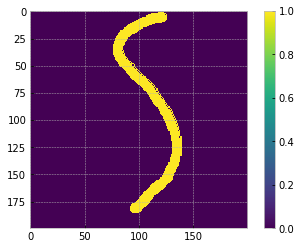

In [131]:
# read hight data from image file (converting RGB values to scalar)
bathymetry = np.sqrt(np.sum(imread('bathymetry.bmp')**2, axis = 2)) > 10
plt.imshow(bathymetry)
plt.colorbar()

[[ 20.    20.    20.   ...,  20.    20.    20.  ]
 [ 19.57  19.57  19.57 ...,  19.57  19.57  19.57]
 [ 19.13  19.13  19.13 ...,  19.13  19.13  19.13]
 ..., 
 [-65.3  -65.3  -65.3  ..., -65.3  -65.3  -65.3 ]
 [-65.74 -65.74 -65.74 ..., -65.74 -65.74 -65.74]
 [-66.17 -66.17 -66.17 ..., -66.17 -66.17 -66.17]]


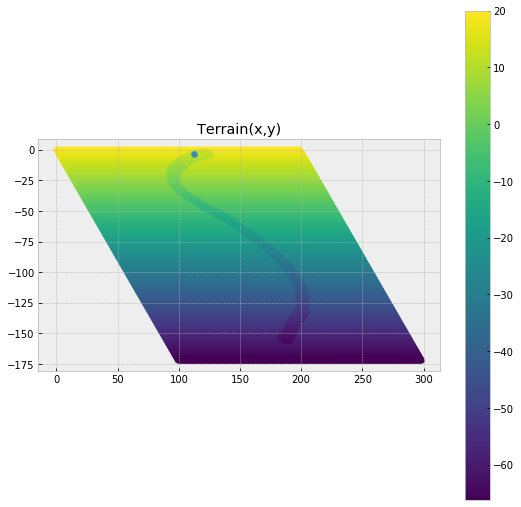

In [132]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
grid = Hexgrid(200,200, terrain = None)
terrain = 20 + 0.5*grid.X[:,:,1] - 5 * bathymetry[:200,:200] 
# terrain = 1 -1*bathymetry[:10,:10]
# terrain = 0.5*grid.X[:,:,0]
# terrain[5,5] = 20
del grid
grid = Hexgrid(200,200, terrain = terrain)

fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, aspect = 'equal')
points = ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.seaBed.flatten())
plt.colorbar(points)
ax.set_title('Terrain(x,y)')
x = 110
y = 4
ax.scatter(grid.X[y, x,0], grid.X[y, x,1]) # Targeting
print(terrain)

In [133]:

startTime = datetime.now()

grid.height[y, x] = 5000

Nt =5000
for i in range(Nt):
#     print('grid.height[1,6] = ', grid.height[1,6])
#     print(np.where(np.logical_and(grid.height != 0, grid.height < np.inf)))
#     print(grid.height[np.where(np.logical_and(grid.height != 0, grid.height < np.inf))])
    
    grid.update_heightNew()
    

print ("Time used to calculate " , i+1 , " timesteps: ", datetime.now() - startTime)
print("Sum of mass in all cells: ", np.sum(grid.height[1:grid.Nx-1,1:grid.Ny-1]))


fig = plt.figure(figsize = (25,25))
ax = fig.add_subplot(131, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.height.flatten())
ax.set_title('Sediment height(x,y)')


#fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(132, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.totalheight.flatten())
ax.set_title('Total Height(x,y)')

# fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(133, aspect = 'equal')
ax.scatter(grid.X[:,:,0].flatten(), grid.X[:,:,1].flatten(), marker = 'h', c = grid.seaBed.flatten())
ax.set_title('Terrain(x,y)')


E:\Users\stein\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in true_divide


> <ipython-input-130-028f0fceac87>(112)update_heightNew()
    111          ipdb.set_trace()
--> 112          print('height',self.height[1,6])
    113 #             print('>1', np.where(NWfrac>=1))



ipdb>  q


BdbQuit: 

In [134]:
grid.height

array([[  inf,   inf,   inf, ...,   inf,   inf,   inf],
       [  inf,  0.  ,  0.  , ...,  0.  ,  0.  ,   inf],
       [  inf,  0.  ,  0.  , ...,  0.  ,  0.  ,   inf],
       ..., 
       [  inf,  0.23,  0.06, ...,  0.  ,  0.  ,   inf],
       [  inf,  0.49,  0.31, ...,  0.  ,  0.  ,   inf],
       [  inf,   inf,   inf, ...,   inf,   inf,   inf]])